In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import random

# used to attain same results everytime despite randomness
random.seed(3)


In [2]:
df = pd.read_csv(r"C:\Users\Ivan Cao\Downloads\ASA All NBA Raw Data.csv")
df['Win'] =  df['Team_Score'] > df['Opponent_Score']
df['team_plus_minus'] = df['Team_Score'] - df['Opponent_Score']

gamestats = df[['game_date', 'H_A', 'Team_Abbrev', 'Team_Score',
       'Opponent_Abbrev', 'Opponent_Score', 'Win', 'team_plus_minus']].drop_duplicates().sort_values(by = ['Team_Abbrev', 'game_date']).reset_index()

playerstats = df[['game_date', 'Team_Abbrev', 'H_A', 'fg', 'fga',
       'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']].drop_duplicates().groupby(['Team_Abbrev', 'game_date']).sum().reset_index()

seasongamestats = pd.merge(gamestats, playerstats)
seasongamestats = seasongamestats.iloc[: , 1:]

seasongamestats['Conference'] = seasongamestats['Team_Abbrev'].isin(['ATL', 'IND', 'BRK', 'CHO', 'MIL', 'CLE', 'BOS', 'CHI','TOR', 'NYK', 'MIA','DET', 'PHI', 'ORL', 'WAS'])
seasongamestats['Conference'] = seasongamestats['Conference'].map({True:'Eastern' ,False:'Western'})


In [3]:

# this function corrects percentage errors when taking sum of all rows
def correct_percent(df, success, attempted, corrected_pct):
    for i,j,k in zip(success, attempted, corrected_pct):
        df[k] = (df[i]/df[j]) * 100
    
    return df

seasongamestats = correct_percent(seasongamestats.copy(), ['fg', 'fg3', 'ft'], ['fga', 'fg3a', 'fta'], ['fg_pct', 'fg3_pct', 'ft_pct'])
seasonhomegames = seasongamestats.loc[seasongamestats['H_A'] == 'H']
seasonawaygames = seasongamestats.loc[seasongamestats['H_A'] == 'A']

In [4]:
def season_stats(game_stats):
    # will be analyzing home games vs away games
    # a full NBA season is 82 games, half are scheduled away (41 games) and half are scheduled home (41 games). 
    # Dividing the rows by 41 will give us averages on home vs away games.
    home_away_totals =  game_stats.groupby(['Team_Abbrev', 'H_A', 'Conference']).sum().div(41).reset_index()
    
    # wins does not need to be divided and percentages need to be corrected
    home_away_totals['Win'] = home_away_totals['Win'].apply(lambda x: x*41)
    home_away_totals = correct_percent(home_away_totals, ['fg', 'fg3', 'ft'], ['fga', 'fg3a', 'fta'], ['fg_pct', 'fg3_pct', 'ft_pct'])
    
    
    pergameaverages = home_away_totals.groupby(['Team_Abbrev', 'Conference']).mean().reset_index()
    pergameaverages['Win'] = pergameaverages['Win'].apply(lambda x: x*2)
    
    stats_at_home = home_away_totals.loc[home_away_totals['H_A'] == 'H']
    stats_at_away = home_away_totals.loc[home_away_totals['H_A'] == 'A']
    
    
    return home_away_totals, stats_at_home, stats_at_away, pergameaverages

seasonbreakdown = season_stats(seasongamestats)
seasontotals = seasonbreakdown[0]
stats_at_home = seasonbreakdown[1]
stats_at_away = seasonbreakdown[2]
pergameaverages = seasonbreakdown[3]
    

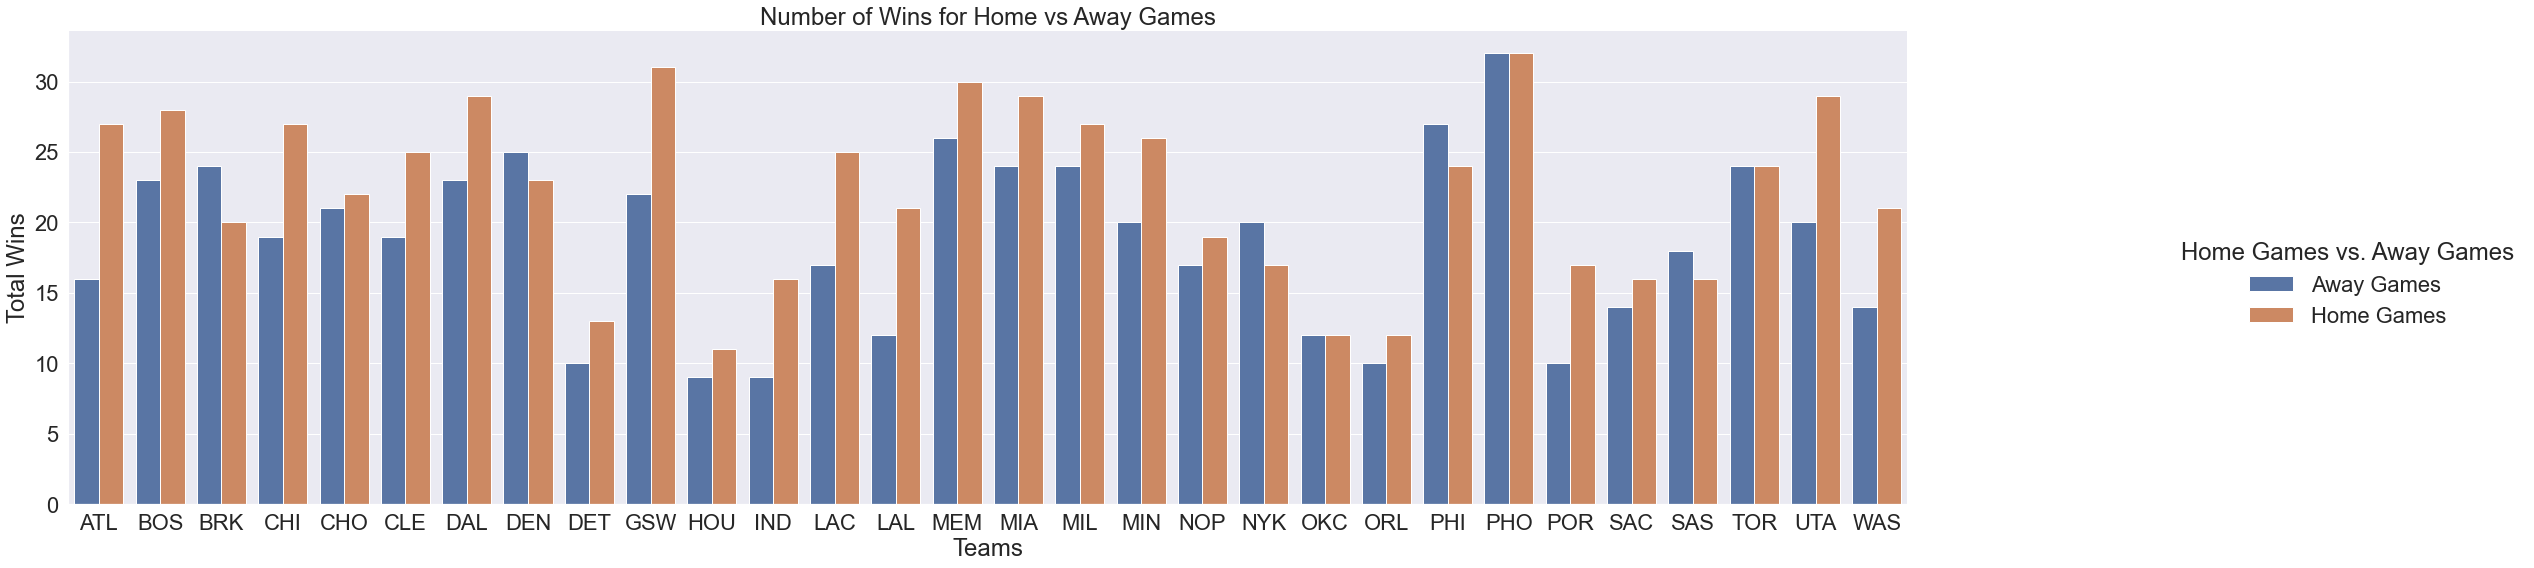

In [80]:

# Historically in the NBA, along with other sports, home teams on average win a larger percentage of the games compared to away teams. We can check this with home 
# and away totals by plotting it
HA_wins = seasontotals[['Team_Abbrev', 'H_A', 'Win']]
HA_wins_plot = sns.catplot(data = HA_wins, kind = 'bar', x = 'Team_Abbrev', y = 'Win', hue = 'H_A')
HA_wins_plot.fig.set_size_inches(40, 8)
HA_wins_plot.set(xlabel = 'Teams', ylabel = 'Total Wins', title = 'Number of Wins for Home vs Away Games')
HA_wins_plot._legend.set_title('Home Games vs. Away Games')
new_labels = ['Away Games', 'Home Games']

for t,l in zip(HA_wins_plot._legend.texts, new_labels):
    t.set_text(l)

    

# Out of the 30 teams, 22 teams (~73%) have more wins at home games than away games.



To set up playoffs, there are 2 conferences: East and West.
Each teams plays their respected conferences and the winner of each conference plays each other in the NBA Finals.
The top 8 teams with the most wins of each conference will make the playoffs (Play-in Tournament results not used).
There are four rounds to the playoffs with teams playing a best of 7 series (first to 4 wins).
The higher ranked team will play home games in games: 1, 2, 5, 7.
The lower ranked team will play home games in games: 3, 4, 6.


The first round of the playoffs are as follows:
The #1 ranked team plays the #8th ranked team, #2 ranked team plays the #7 ranked team, 
the #3 ranked team plays the 6th ranked team, and the 4th ranked team plays the 5th ranked team
I have provided a diagram that outlines the bracket:



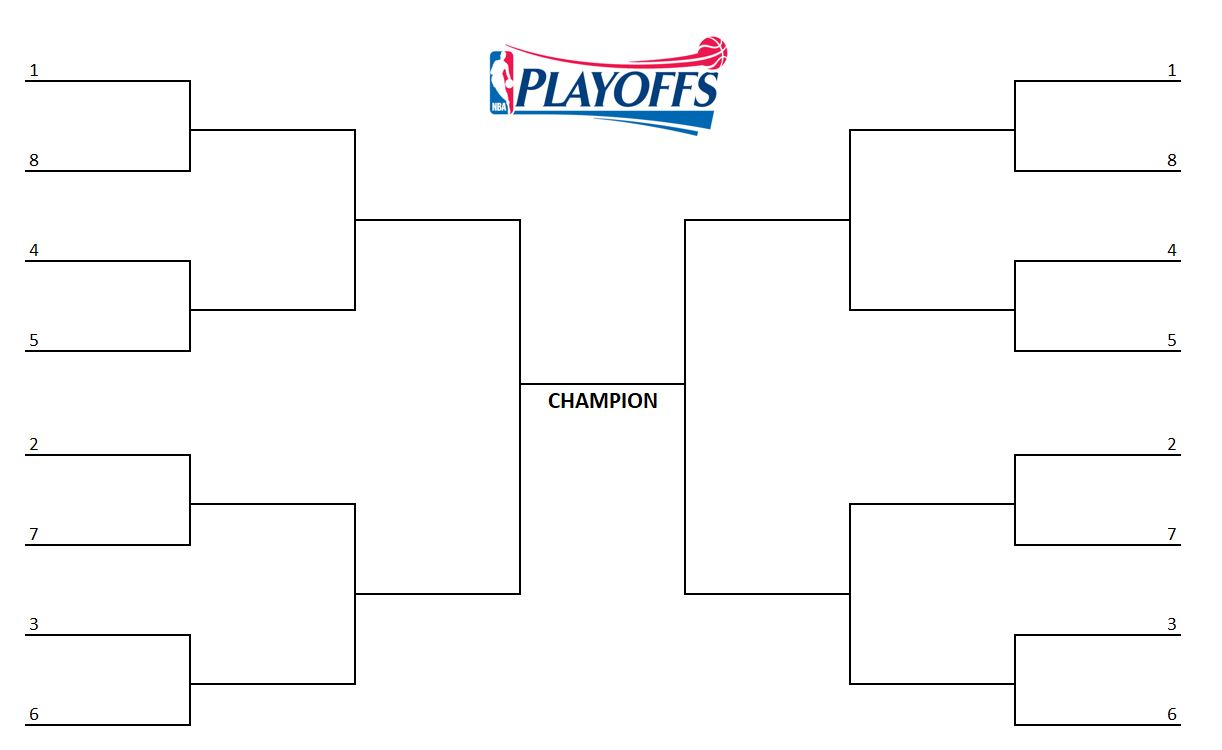

In [8]:

# The 16 teams that made the playoffs played 1312 season games collectively, 
# however I only want to pull the games that have been played against playoff contenders. 
# This will eliminate games against the worst teams in the league. 
# This changes the total to only 676 games amongst the 16 playoff contending teams
playoffmatchupsstats = seasongamestats.loc[seasongamestats['Team_Abbrev'].isin(regularseasonplayoffteamstats['Team_Abbrev'])]
playoffmatchupsstats = playoffmatchupsstats.loc[playoffmatchupsstats['Opponent_Abbrev'].isin(regularseasonplayoffteamstats['Team_Abbrev'])]


In [9]:

# Creating a dictionary to store the results of the simulation 

NBA_team_final_wins = dict.fromkeys(playoffmatchupsstats['Team_Abbrev'], 0)
NBA_team_finals_appearance = dict.fromkeys(playoffmatchupsstats['Team_Abbrev'], 0)


for i in range(10000):
    # uncomment to show progress of the 10,000 simulations
    # print(i) 
    
    # This function creates the playoff bracket in each round
    
    def playoff_bracket(Conference):
        bracket = []
        for i in range(len(Conference)//2):
            bracket.append(pd.concat([Conference.iloc[i], Conference.iloc[len(Conference) - 1 - i]], axis = 1, ignore_index = True). T)
            
        return bracket
    
    Western_seeding = playoff_bracket(WesternConference)
    Eastern_seeding = playoff_bracket(EasternConference)
    
    # This function pulls the data that the teams have played against playoff contenders.
    def playoff_round_sim(Conference, playoffmatchupsstats):
        teams = []
        
        for i in range(len(Conference)):
            higher_ranked = Conference[i]['Team_Abbrev'][0]
            lower_ranked = Conference[i]['Team_Abbrev'][1]
            
            higher_ranked_games = playoffmatchupsstats.loc[playoffmatchupsstats['Team_Abbrev'] == higher_ranked]
            lower_ranked_games = playoffmatchupsstats.loc[playoffmatchupsstats['Team_Abbrev'] == lower_ranked]
            
            higher_ranked_name = higher_ranked_games['Team_Abbrev'].iloc[0]
            lower_ranked_name = lower_ranked_games['Team_Abbrev'].iloc[0]
            
            teams.append([higher_ranked_games, lower_ranked_games, higher_ranked_name, lower_ranked_name])
            
        return teams
        
    
    # This function simulates the best of 7 series and returns the scores for each game. 
    # First team to 4 wins advances to the next round. 
    # Home court is given to the higher seeded team in games 1, 2, and (5, 7 if needed), 
    # and Home court is given to the lower seeded teams in games 3, 4, (6, if needed)
    def playoff_game_sim(higher_ranked, lower_ranked, highername, lowername):
        game_counter = 1
        higher_ranked_wins = lower_ranked_wins = 0
        higher_ranked_scoreboard = []
        lower_ranked_scoreboard = []
    
        higher_ranked_home, higher_ranked_away = higher_ranked.loc[higher_ranked['H_A'] == 'H'], higher_ranked.loc[higher_ranked['H_A'] == 'A']
        lower_ranked_home, lower_ranked_away = lower_ranked.loc[lower_ranked['H_A'] == 'H'], lower_ranked.loc[lower_ranked['H_A'] == 'A'] 
        
        while higher_ranked_wins < 4 and lower_ranked_wins < 4:
            # determine home or away stats to look at
            if game_counter in [1, 2, 5, 7]:
                
                # this while loop is needed for rare cases in which higher_ranked_score equals to lower_ranked_score
                while True:
                    higher_ranked_score = (random.gauss(higher_ranked_home['Team_Score'].mean(), higher_ranked_home['Team_Score'].std()) +
                                       random.gauss(lower_ranked_away['Opponent_Score'].mean(), lower_ranked_away['Opponent_Score'].std()))//2
                                    
                    lower_ranked_score = (random.gauss(lower_ranked_away['Team_Score'].mean(), lower_ranked_away['Team_Score'].std()) +
                                      random.gauss(higher_ranked_home['Opponent_Score'].mean(), higher_ranked_home['Opponent_Score'].std()))//2
                
                    if higher_ranked_score != lower_ranked_score:
                        if higher_ranked_score > lower_ranked_score:
                            higher_ranked_wins += 1
                        else:
                            lower_ranked_wins += 1
                        
                        higher_ranked_scoreboard.append(higher_ranked_score)
                        lower_ranked_scoreboard.append(lower_ranked_score)
                        break
                
            else:
                # this while loop is needed for rare cases in which higher_ranked_score equals to lower_ranked_score
                while True:
                
                    higher_ranked_score = (random.gauss(higher_ranked_away['Opponent_Score'].mean(), higher_ranked_away['Opponent_Score'].std()) +
                                           random.gauss(lower_ranked_home['Team_Score'].mean(), higher_ranked_home['Team_Score'].std()))//2
        
                    lower_ranked_score = (random.gauss(lower_ranked_away['Opponent_Score'].mean(), lower_ranked_away['Opponent_Score'].std()) +
                                          random.gauss(higher_ranked_home['Team_Score'].mean(), higher_ranked_home['Team_Score'].std()))//2        
        
                    if higher_ranked_score != lower_ranked_score:
                        if higher_ranked_score > lower_ranked_score:
                            higher_ranked_wins += 1
                        else:
                            lower_ranked_wins += 1
                        
                        
                        higher_ranked_scoreboard.append(higher_ranked_score)
                        lower_ranked_scoreboard.append(lower_ranked_score)
                        break
                
            game_counter += 1
        
        scorecounter = pd.concat([pd.Series(higher_ranked_scoreboard), pd.Series(lower_ranked_scoreboard)], axis = 1)
        scorecounter.columns = [highername, lowername]
        advancedteam = highername if higher_ranked_wins > lower_ranked_wins else lowername
        
        
        return scorecounter, higher_ranked_wins, lower_ranked_wins, advancedteam
    
    
    def simulation_helper(conference, prev_round, playoffmatchupsstats):
        round_seeding = []
        
        for i in range(len(prev_round)):
            round_seeding.append(conference.loc[conference['Team_Abbrev'] == prev_round[i][3]])
        
        round_seeding_df = pd.concat(round_seeding)
        
        round_seeding = playoff_bracket(round_seeding_df)
        
        round_sim = playoff_round_sim(round_seeding, playoffmatchupsstats)
        
        simulated_round = []
        
        for i in range(len(round_sim)):
            simulated_round.append(playoff_game_sim(round_sim[i][0], round_sim[i][1], round_sim[i][2], round_sim[i][3]))
        
        return simulated_round
    
    
    def simulated_data(conference, seeding, playoffmatchupsstats):
        
        first_round = playoff_round_sim(seeding, playoffmatchupsstats)
        
        res = []
        for i in range(len(first_round)):
            res.append(playoff_game_sim(first_round[i][0], first_round[i][1], first_round[i][2], first_round[i][3]))
            
        second_round = simulation_helper(conference, res, playoffmatchupsstats)
        
        third_round = simulation_helper(conference, second_round, playoffmatchupsstats)
        
        return res, second_round, third_round
    
    WesternConferencePlayoffSimulated = simulated_data(WesternConference, Western_seeding, playoffmatchupsstats)
    EasternConferencePlayoffSimulated = simulated_data(EasternConference, Eastern_seeding, playoffmatchupsstats)
    
    # NBA Finals are simulated separate from the rest of the rounds as teams from different conferences come together.
    
    def NBA_Final_Sim(WesternConferencePlayoffSim, EasternConferencePlayoffSim, playoffmatchupsstats, WesternRanking, EasternRanking):
        WesternConferenceChampion = WesternConferencePlayoffSimulated[2][0][3]
        EasternConferenceChampion = EasternConferencePlayoffSimulated[2][0][3]
        
        teams_data = pd.concat([WesternRanking.loc[WesternRanking['Team_Abbrev'] == WesternConferenceChampion], EasternRanking.loc[EasternRanking['Team_Abbrev'] == EasternConferenceChampion]]).reset_index()
        
        higher_ranked_games = playoffmatchupsstats.loc[playoffmatchupsstats['Team_Abbrev'] == teams_data['Team_Abbrev'].iloc[0]]
        lower_ranked_games = playoffmatchupsstats.loc[playoffmatchupsstats['Team_Abbrev'] == teams_data['Team_Abbrev'].iloc[1]]
        
        higher_ranked_name = higher_ranked_games['Team_Abbrev'].iloc[0]
        lower_ranked_name = lower_ranked_games['Team_Abbrev'].iloc[0]    
        
        NBA_finals_sim = playoff_game_sim(higher_ranked_games, lower_ranked_games, higher_ranked_name, lower_ranked_name)
        
        #print(NBA_finals_sim[3], "has won the 2021-2022 NBA Finals")
        
        return NBA_finals_sim
    
    NBA_Finals = NBA_Final_Sim(WesternConferencePlayoffSimulated, EasternConferencePlayoffSimulated, playoffmatchupsstats,WesternConference, EasternConference)
    
    NBA_team_final_wins[NBA_Finals[3]] += 1
    
    for i in NBA_Finals[0].columns.tolist():
        NBA_team_finals_appearance[i] += 1

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# By simulating the playoffs 10,000 times, values will converge giving a more accurate representation of how playoffs will likely play out.


In [14]:
# Plotting the results of the simulations.
%matplotlib inline
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# By simulating the playoffs 10,000 times, values will converge giving a more accurate representation of how 
# playoffs will likely play out.

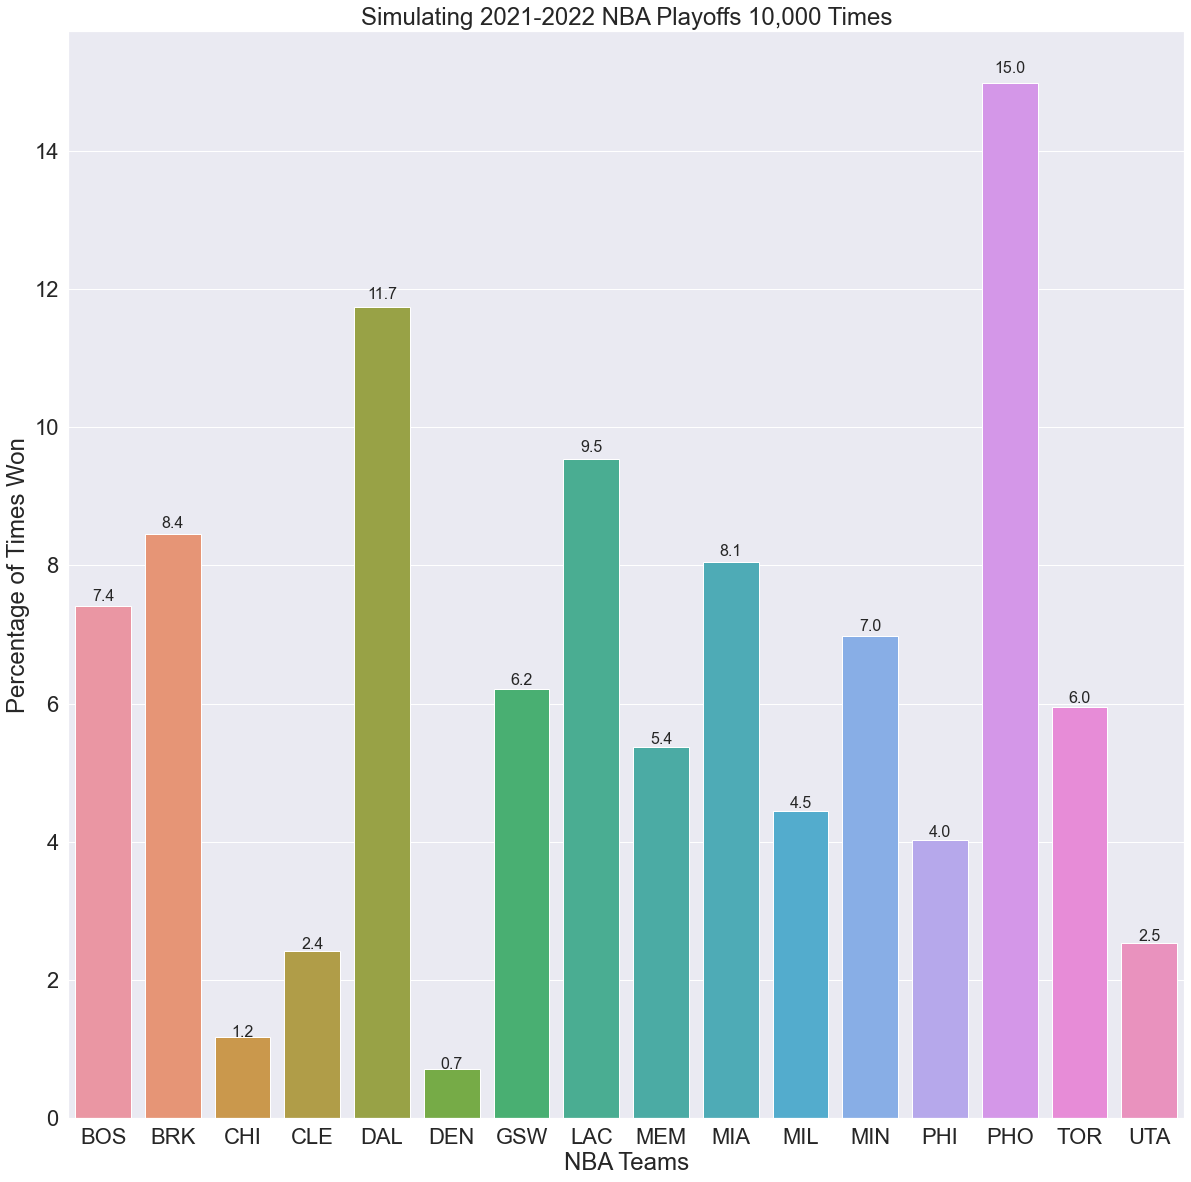

In [81]:

nba_teams = list(NBA_team_final_wins.keys())
nba_teams_wins = [i / 100 for i in list(NBA_team_final_wins.values())]

NBA_teams_plot = sns.barplot(x = nba_teams, y = nba_teams_wins, ci = None)

NBA_teams_plot.set(xlabel = 'NBA Teams', ylabel = 'Percentage of Times Won', title = 'Simulating 2021-2022 NBA Playoffs 10,000 Times')
show_values(NBA_teams_plot)


After simulating the playoffs 10000 times, the Phoenix Suns wins 15% of the time, second is Dallas Mavericks winning 11.7%. The least likely team to win the NBA Finals are the Denver Nuggets and the Chicago Bulls winning .7% and 1.2% of the time respectively.



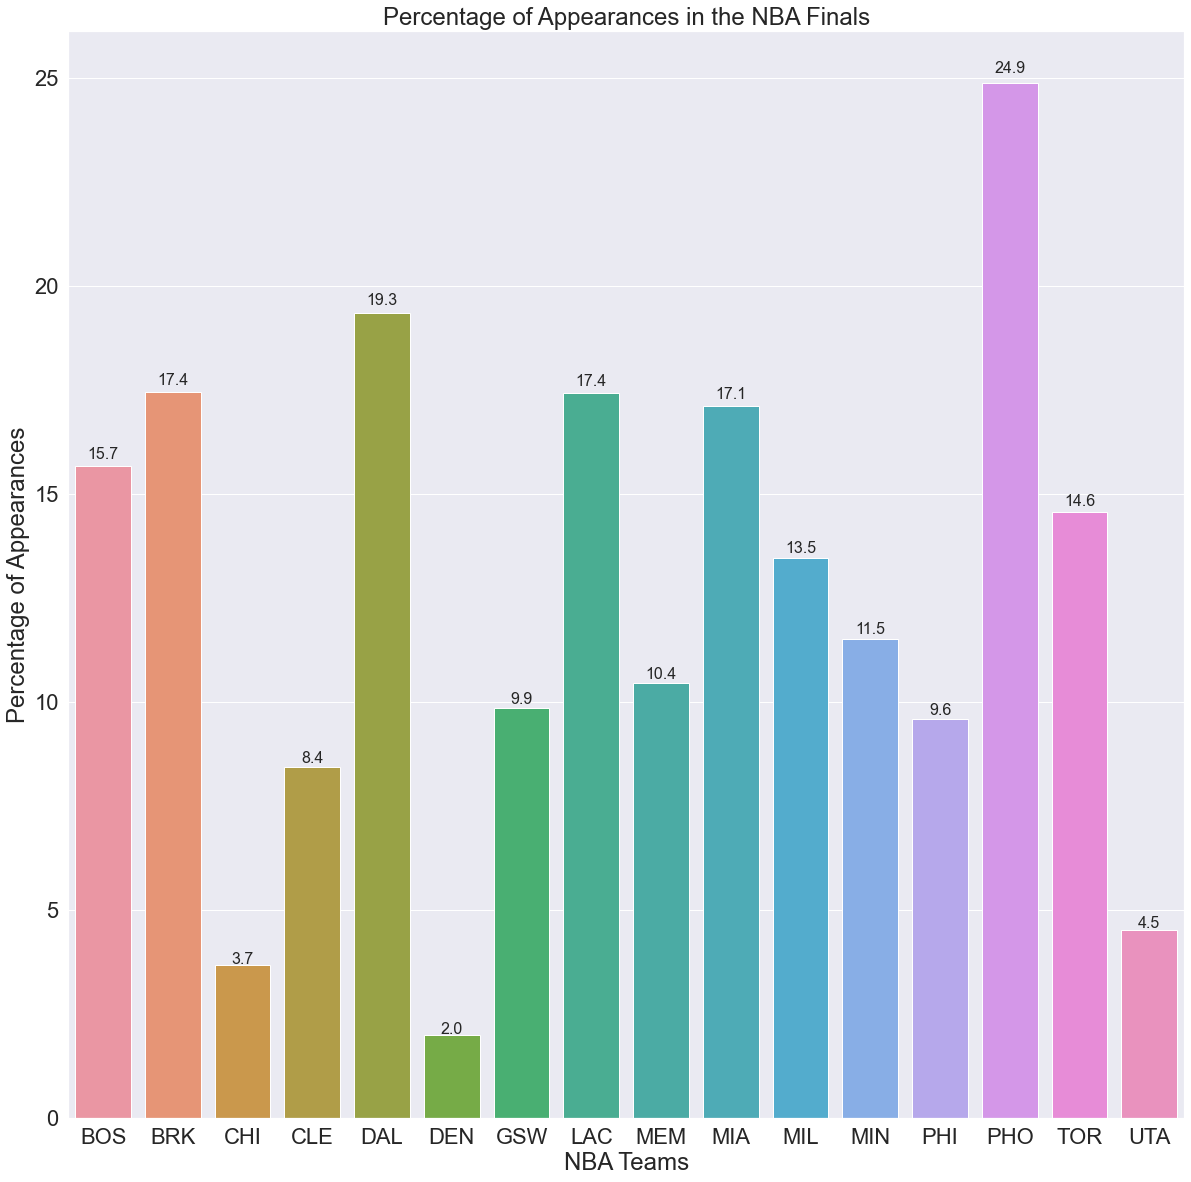

In [68]:


nba_teams_appearances = [i/100 for i in list(NBA_team_finals_appearance.values())]

NBA_teams_appearances_plot = sns.barplot(x = nba_teams, y = nba_teams_appearances, ci = None)
NBA_teams_appearances_plot.set(xlabel = 'NBA Teams', ylabel = 'Percentage of Appearances', title = 'Percentage of Appearances in the NBA Finals')
show_values(NBA_teams_appearances_plot)


With this plot, we can see that the Phoenix Suns make the NBA Finals 24.9% of the 10,000 simulations, the Dallas Mavericks make the NBA Finals 19.3% of the time.
The teams least likely to make the NBA Finals are the Denver Nuggets and the Chicago Bulls making it 2% and 3.7% of the times respectively.


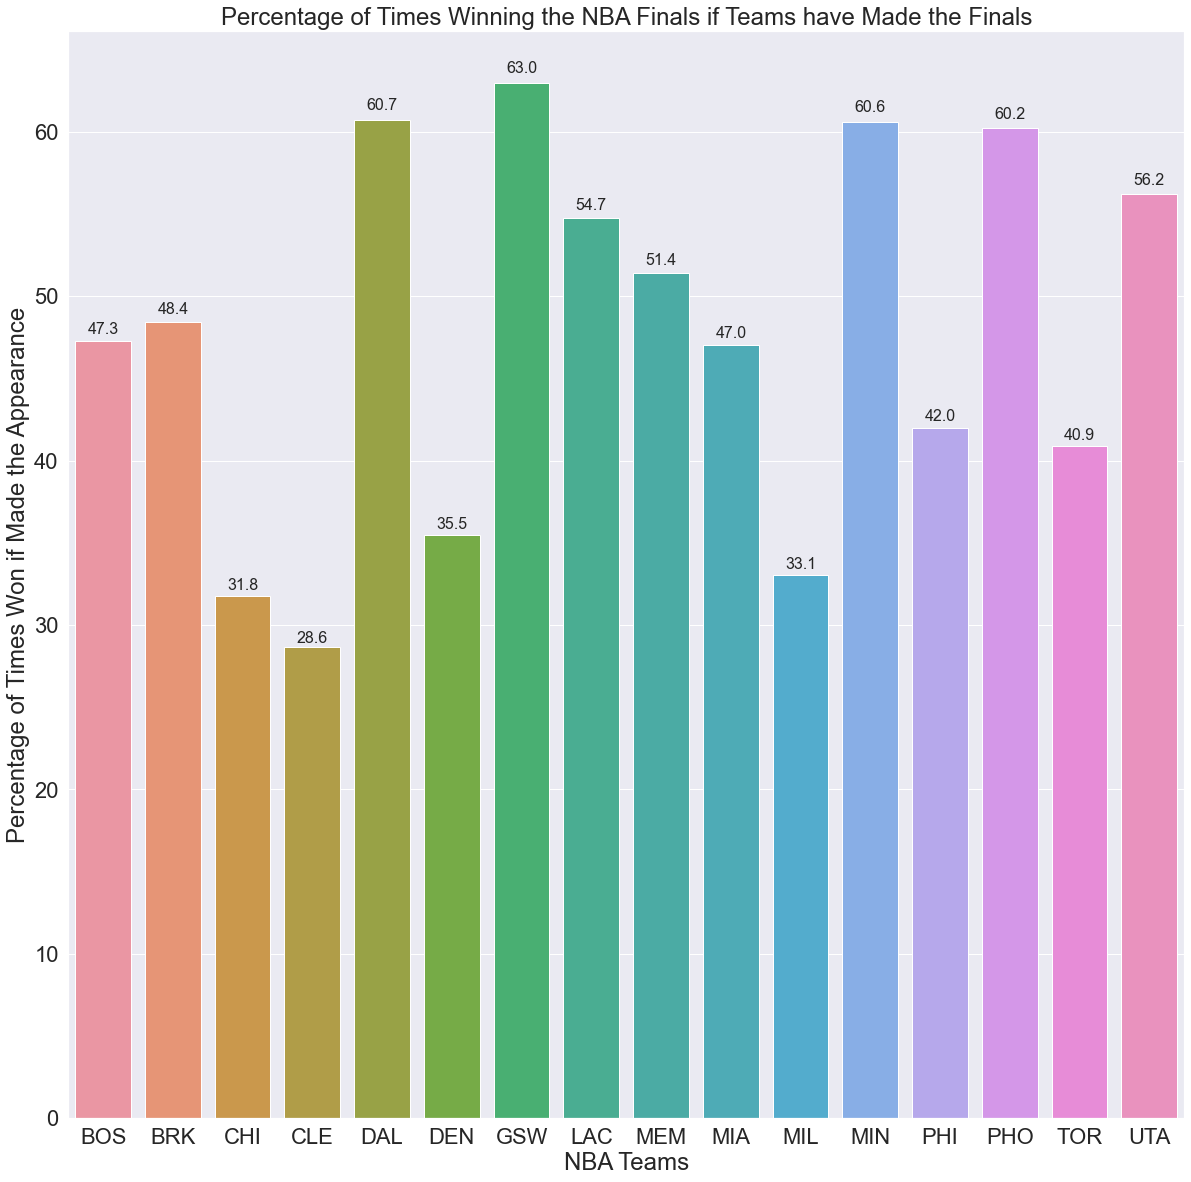

In [69]:

# Plotting the percentage of times winning the NBA Finals for each team if they made it
nba_teams_percentage_won = [j*100 for j in list({i:float(NBA_team_final_wins[i])/NBA_team_finals_appearance[i] for i in NBA_team_finals_appearance}.values())]

nba_teams_percentage_won_plot = sns.barplot(x = nba_teams, y = nba_teams_percentage_won, ci = None)
nba_teams_percentage_won_plot.set(xlabel = 'NBA Teams', ylabel = 'Percentage of Times Won if Made the Appearance', title = 'Percentage of Times Winning the NBA Finals if Teams have Made the Finals')
show_values(nba_teams_percentage_won_plot)


With this plot, we can see that the Golden State Warriors have the highest chance of winning the NBA Finals if they made it,
they end up winning 63% of the time. The Dallas Mavericks win 60.7% of the time when they make it to the finals.
The least likely team to win NBA Finals when making it is the Chicago Bulls and the Cleveland Cavaliers winning 28.6% and 31.8% respectively.